In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:16 - loss: 0.2013 - STD: 1.0029e-04 - MAE: 0.4374

 4/64 [>.............................] - ETA: 2s - loss: 0.0680 - STD: 3.3235e-04 - MAE: 0.2007  

 5/64 [=>............................] - ETA: 2s - loss: 0.0586 - STD: 2.9384e-04 - MAE: 0.1823

 6/64 [=>............................] - ETA: 2s - loss: 0.0528 - STD: 2.5853e-04 - MAE: 0.1725

 7/64 [==>...........................] - ETA: 2s - loss: 0.0492 - STD: 2.2861e-04 - MAE: 0.1669

 8/64 [==>...........................] - ETA: 2s - loss: 0.0467 - STD: 2.0377e-04 - MAE: 0.1634

 9/64 [===>..........................] - ETA: 2s - loss: 0.0448 - STD: 1.8315e-04 - MAE: 0.1611

10/64 [===>..........................] - ETA: 2s - loss: 0.0434 - STD: 1.6584e-04 - MAE: 0.1595

11/64 [====>.........................] - ETA: 2s - loss: 0.0422 - STD: 1.5120e-04 - MAE: 0.1581

12/64 [====>.........................] - ETA: 2s - loss: 0.0412 - STD: 1.3902e-04 - MAE: 0.1568

13/64 [=====>........................] - ETA: 2s - loss: 0.0404 - STD: 1.2892e-04 - MAE: 0.1558

14/64 [=====>........................] - ETA: 2s - loss: 0.0396 - STD: 1.2056e-04 - MAE: 0.1547

15/64 [======>.......................] - ETA: 2s - loss: 0.0389 - STD: 1.1348e-04 - MAE: 0.1535

16/64 [======>.......................] - ETA: 2s - loss: 0.0382 - STD: 1.0754e-04 - MAE: 0.1524

17/64 [======>.......................] - ETA: 2s - loss: 0.0375 - STD: 1.0244e-04 - MAE: 0.1511

18/64 [=======>......................] - ETA: 2s - loss: 0.0367 - STD: 9.8022e-05 - MAE: 0.1494

19/64 [=======>......................] - ETA: 2s - loss: 0.0360 - STD: 9.4142e-05 - MAE: 0.1477

20/64 [========>.....................] - ETA: 2s - loss: 0.0352 - STD: 9.0688e-05 - MAE: 0.1457

21/64 [========>.....................] - ETA: 2s - loss: 0.0344 - STD: 8.7676e-05 - MAE: 0.1436

22/64 [=========>....................] - ETA: 2s - loss: 0.0336 - STD: 8.4989e-05 - MAE: 0.1413

23/64 [=========>....................] - ETA: 2s - loss: 0.0327 - STD: 8.2613e-05 - MAE: 0.1389

24/64 [==========>...................] - ETA: 2s - loss: 0.0319 - STD: 8.0553e-05 - MAE: 0.1365

25/64 [==========>...................] - ETA: 2s - loss: 0.0311 - STD: 7.8723e-05 - MAE: 0.1341

26/64 [===========>..................] - ETA: 2s - loss: 0.0303 - STD: 7.7079e-05 - MAE: 0.1319

27/64 [===========>..................] - ETA: 2s - loss: 0.0295 - STD: 7.5634e-05 - MAE: 0.1299

28/64 [============>.................] - ETA: 2s - loss: 0.0288 - STD: 7.4294e-05 - MAE: 0.1282

29/64 [============>.................] - ETA: 2s - loss: 0.0282 - STD: 7.3033e-05 - MAE: 0.1268

30/64 [=============>................] - ETA: 2s - loss: 0.0277 - STD: 7.1811e-05 - MAE: 0.1256

31/64 [=============>................] - ETA: 2s - loss: 0.0272 - STD: 7.0616e-05 - MAE: 0.1247

32/64 [==============>...............] - ETA: 1s - loss: 0.0267 - STD: 6.9425e-05 - MAE: 0.1238

33/64 [==============>...............] - ETA: 1s - loss: 0.0263 - STD: 6.8211e-05 - MAE: 0.1230

34/64 [==============>...............] - ETA: 1s - loss: 0.0259 - STD: 6.7026e-05 - MAE: 0.1222

35/64 [===============>..............] - ETA: 1s - loss: 0.0255 - STD: 6.5818e-05 - MAE: 0.1212

36/64 [===============>..............] - ETA: 1s - loss: 0.0251 - STD: 6.4592e-05 - MAE: 0.1203

37/64 [================>.............] - ETA: 1s - loss: 0.0247 - STD: 6.3370e-05 - MAE: 0.1192

38/64 [================>.............] - ETA: 1s - loss: 0.0243 - STD: 6.2164e-05 - MAE: 0.1182

39/64 [=================>............] - ETA: 1s - loss: 0.0239 - STD: 6.1000e-05 - MAE: 0.1171

40/64 [=================>............] - ETA: 1s - loss: 0.0236 - STD: 5.9843e-05 - MAE: 0.1161

41/64 [==================>...........] - ETA: 1s - loss: 0.0233 - STD: 5.8722e-05 - MAE: 0.1152

42/64 [==================>...........] - ETA: 1s - loss: 0.0232 - STD: 5.7591e-05 - MAE: 0.1143

46/64 [====================>.........] - ETA: 1s - loss: 0.0221 - STD: 5.3529e-05 - MAE: 0.1109

47/64 [=====================>........] - ETA: 1s - loss: 0.0218 - STD: 5.2624e-05 - MAE: 0.1101

48/64 [=====================>........] - ETA: 1s - loss: 0.0216 - STD: 5.1765e-05 - MAE: 0.1094

49/64 [=====================>........] - ETA: 1s - loss: 0.0214 - STD: 5.0981e-05 - MAE: 0.1088

50/64 [======================>.......] - ETA: 0s - loss: 0.0212 - STD: 5.0180e-05 - MAE: 0.1081

51/64 [======================>.......] - ETA: 0s - loss: 0.0209 - STD: 4.9409e-05 - MAE: 0.1075

52/64 [=======================>......] - ETA: 0s - loss: 0.0207 - STD: 4.8702e-05 - MAE: 0.1069

53/64 [=======================>......] - ETA: 0s - loss: 0.0205 - STD: 4.8018e-05 - MAE: 0.1064

54/64 [========================>.....] - ETA: 0s - loss: 0.0203 - STD: 4.7338e-05 - MAE: 0.1059

55/64 [========================>.....] - ETA: 0s - loss: 0.0201 - STD: 4.6691e-05 - MAE: 0.1054

56/64 [=========================>....] - ETA: 0s - loss: 0.0199 - STD: 4.6070e-05 - MAE: 0.1050

57/64 [=========================>....] - ETA: 0s - loss: 0.0198 - STD: 4.5473e-05 - MAE: 0.1046

58/64 [==========================>...] - ETA: 0s - loss: 0.0196 - STD: 4.4898e-05 - MAE: 0.1042

59/64 [==========================>...] - ETA: 0s - loss: 0.0194 - STD: 4.4325e-05 - MAE: 0.1038

60/64 [===========================>..] - ETA: 0s - loss: 0.0193 - STD: 4.3784e-05 - MAE: 0.1034

61/64 [===========================>..] - ETA: 0s - loss: 0.0191 - STD: 4.3255e-05 - MAE: 0.1030

62/64 [============================>.] - ETA: 0s - loss: 0.0190 - STD: 4.2741e-05 - MAE: 0.1027

63/64 [============================>.] - ETA: 0s - loss: 0.0188 - STD: 4.2246e-05 - MAE: 0.1023

64/64 [==============================] - ETA: 0s - loss: 0.0187 - STD: 4.1759e-05 - MAE: 0.1019

64/64 [==============================] - 6s 76ms/step - loss: 0.0187 - STD: 4.1759e-05 - MAE: 0.1019 - val_loss: 0.0094 - val_STD: 1.0875e-05 - val_MAE: 0.0765


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 1.2228e-05 - MAE: 0.0777

 2/64 [..............................] - ETA: 3s - loss: 0.0099 - STD: 1.1185e-05 - MAE: 0.0778

 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.1309e-05 - MAE: 0.0774

 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 1.1219e-05 - MAE: 0.0772

 5/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 1.1196e-05 - MAE: 0.0771

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.1236e-05 - MAE: 0.0770

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.1270e-05 - MAE: 0.0769

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.1255e-05 - MAE: 0.0769

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.1174e-05 - MAE: 0.0770

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.1075e-05 - MAE: 0.0770

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.1055e-05 - MAE: 0.0771

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.1178e-05 - MAE: 0.0772

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.1162e-05 - MAE: 0.0772

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.1245e-05 - MAE: 0.0773

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1385e-05 - MAE: 0.0774

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.1459e-05 - MAE: 0.0774

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.1469e-05 - MAE: 0.0775

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.1488e-05 - MAE: 0.0776

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.1505e-05 - MAE: 0.0776

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.1571e-05 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.1649e-05 - MAE: 0.0777

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.1755e-05 - MAE: 0.0777

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.1810e-05 - MAE: 0.0777

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.1829e-05 - MAE: 0.0777

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.1910e-05 - MAE: 0.0777

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.1917e-05 - MAE: 0.0777

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.1977e-05 - MAE: 0.0777

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.2048e-05 - MAE: 0.0777

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.2103e-05 - MAE: 0.0776

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.2166e-05 - MAE: 0.0777

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.2233e-05 - MAE: 0.0776

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.2307e-05 - MAE: 0.0777

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.2345e-05 - MAE: 0.0777

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.2387e-05 - MAE: 0.0777

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.2449e-05 - MAE: 0.0777

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.2512e-05 - MAE: 0.0777

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.2590e-05 - MAE: 0.0777

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.2688e-05 - MAE: 0.0777

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.2780e-05 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.2874e-05 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.2969e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.3064e-05 - MAE: 0.0778

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.3142e-05 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.3202e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.3333e-05 - MAE: 0.0777

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.3407e-05 - MAE: 0.0777

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.3493e-05 - MAE: 0.0777

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.3583e-05 - MAE: 0.0777

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.3670e-05 - MAE: 0.0777

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.3758e-05 - MAE: 0.0777

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.3850e-05 - MAE: 0.0777

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.3935e-05 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.4021e-05 - MAE: 0.0777

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.4122e-05 - MAE: 0.0777

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.4210e-05 - MAE: 0.0777

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.4289e-05 - MAE: 0.0777

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.4371e-05 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.4474e-05 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4586e-05 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4700e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.4811e-05 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.4920e-05 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.5019e-05 - MAE: 0.0778

64/64 [==============================] - 4s 65ms/step - loss: 0.0099 - STD: 1.5019e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 1.7201e-05 - val_MAE: 0.0766


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 2.0626e-05 - MAE: 0.0774

 2/64 [..............................] - ETA: 4s - loss: 0.0100 - STD: 2.0947e-05 - MAE: 0.0779

 3/64 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 2.1387e-05 - MAE: 0.0779

 4/64 [>.............................] - ETA: 4s - loss: 0.0101 - STD: 2.1872e-05 - MAE: 0.0782

 5/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 2.2298e-05 - MAE: 0.0782

 6/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 2.2625e-05 - MAE: 0.0782

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 2.2927e-05 - MAE: 0.0782

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 2.3183e-05 - MAE: 0.0781

 9/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 2.3456e-05 - MAE: 0.0781

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 2.3752e-05 - MAE: 0.0781

11/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 2.4044e-05 - MAE: 0.0781

12/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 2.4262e-05 - MAE: 0.0781

13/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 2.4504e-05 - MAE: 0.0782

14/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 2.4741e-05 - MAE: 0.0781

15/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 2.4983e-05 - MAE: 0.0782

16/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 2.5169e-05 - MAE: 0.0782

17/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 2.5366e-05 - MAE: 0.0781

18/64 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 2.5543e-05 - MAE: 0.0782

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 2.5668e-05 - MAE: 0.0781

21/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 2.5932e-05 - MAE: 0.0782

22/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 2.6112e-05 - MAE: 0.0782

23/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 2.6290e-05 - MAE: 0.0782

24/64 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 2.6484e-05 - MAE: 0.0782

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.6661e-05 - MAE: 0.0782

26/64 [===========>..................] - ETA: 2s - loss: 0.0100 - STD: 2.6869e-05 - MAE: 0.0782

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.7093e-05 - MAE: 0.0782

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.7335e-05 - MAE: 0.0782

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.7566e-05 - MAE: 0.0782

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.7782e-05 - MAE: 0.0782

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.7980e-05 - MAE: 0.0782

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.8181e-05 - MAE: 0.0781

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.8410e-05 - MAE: 0.0781

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.8656e-05 - MAE: 0.0781

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.8935e-05 - MAE: 0.0781

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.9235e-05 - MAE: 0.0781

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.9537e-05 - MAE: 0.0781

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.9841e-05 - MAE: 0.0781

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.0147e-05 - MAE: 0.0781

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.0445e-05 - MAE: 0.0781

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.0740e-05 - MAE: 0.0780

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.1042e-05 - MAE: 0.0780

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.1354e-05 - MAE: 0.0780

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.1650e-05 - MAE: 0.0780

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.1941e-05 - MAE: 0.0780

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.2229e-05 - MAE: 0.0780

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.2536e-05 - MAE: 0.0780

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.2862e-05 - MAE: 0.0780

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.3192e-05 - MAE: 0.0780

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.3527e-05 - MAE: 0.0780

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.3863e-05 - MAE: 0.0780

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.4217e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.4582e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.4963e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.5349e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.5728e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.6117e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.6511e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.6913e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.7336e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.7775e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.8202e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.8635e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 3.9065e-05 - MAE: 0.0779

64/64 [==============================] - 4s 69ms/step - loss: 0.0099 - STD: 3.9065e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 4.9473e-05 - val_MAE: 0.0763


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0096 - STD: 6.7979e-05 - MAE: 0.0767

 2/64 [..............................] - ETA: 4s - loss: 0.0097 - STD: 6.8931e-05 - MAE: 0.0773

 3/64 [>.............................] - ETA: 4s - loss: 0.0097 - STD: 6.9642e-05 - MAE: 0.0773

 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 7.0234e-05 - MAE: 0.0774

 5/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 7.0937e-05 - MAE: 0.0773

 6/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 7.1591e-05 - MAE: 0.0774

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 7.2461e-05 - MAE: 0.0775

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 7.3452e-05 - MAE: 0.0775

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 7.4510e-05 - MAE: 0.0775

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 7.5475e-05 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 7.6454e-05 - MAE: 0.0776

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 7.7534e-05 - MAE: 0.0776

13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 7.8565e-05 - MAE: 0.0776

14/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 7.9585e-05 - MAE: 0.0776

15/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 8.0621e-05 - MAE: 0.0776

16/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 8.1716e-05 - MAE: 0.0776

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 8.2775e-05 - MAE: 0.0777

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 8.3895e-05 - MAE: 0.0778

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 8.5081e-05 - MAE: 0.0778

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.6328e-05 - MAE: 0.0778

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.7607e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 8.8825e-05 - MAE: 0.0778

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 9.0100e-05 - MAE: 0.0778

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 9.1454e-05 - MAE: 0.0778

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 9.2830e-05 - MAE: 0.0779

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 9.4232e-05 - MAE: 0.0778

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 9.5644e-05 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 9.7038e-05 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 9.8489e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.0004e-04 - MAE: 0.0778

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.0159e-04 - MAE: 0.0778

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.0323e-04 - MAE: 0.0778

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.0493e-04 - MAE: 0.0778

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.0674e-04 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.0856e-04 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.1043e-04 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.1234e-04 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.1437e-04 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.1642e-04 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.1849e-04 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.2064e-04 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.2282e-04 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.2503e-04 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.2740e-04 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.2983e-04 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.3228e-04 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.3491e-04 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.3754e-04 - MAE: 0.0779

49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.4027e-04 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.4619e-04 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.4932e-04 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.5256e-04 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.5591e-04 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.5935e-04 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.6285e-04 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.6642e-04 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.7015e-04 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.7401e-04 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.7798e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.8209e-04 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.8631e-04 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.9076e-04 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.9539e-04 - MAE: 0.0778

64/64 [==============================] - 4s 69ms/step - loss: 0.0099 - STD: 1.9539e-04 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 3.6323e-04 - val_MAE: 0.0763


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0097 - STD: 5.0617e-04 - MAE: 0.0774

 2/64 [..............................] - ETA: 3s - loss: 0.0096 - STD: 5.1511e-04 - MAE: 0.0768

 3/64 [>.............................] - ETA: 3s - loss: 0.0096 - STD: 5.2741e-04 - MAE: 0.0768

 4/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 5.3950e-04 - MAE: 0.0773

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 5.6425e-04 - MAE: 0.0773

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 5.7753e-04 - MAE: 0.0776

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 5.9067e-04 - MAE: 0.0775

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 6.0447e-04 - MAE: 0.0776

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 6.1908e-04 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 6.3364e-04 - MAE: 0.0776

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 6.4876e-04 - MAE: 0.0776

13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 6.6444e-04 - MAE: 0.0776

14/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 6.8037e-04 - MAE: 0.0776

15/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 6.9688e-04 - MAE: 0.0776

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 7.1400e-04 - MAE: 0.0776

17/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 7.3210e-04 - MAE: 0.0776

18/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 7.5082e-04 - MAE: 0.0776

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 7.7031e-04 - MAE: 0.0776

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 7.8976e-04 - MAE: 0.0776

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.1070e-04 - MAE: 0.0776

22/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 8.3272e-04 - MAE: 0.0776

23/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 8.5500e-04 - MAE: 0.0776

24/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 8.7876e-04 - MAE: 0.0776

25/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 9.0319e-04 - MAE: 0.0776

26/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 9.2878e-04 - MAE: 0.0775

27/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 9.5543e-04 - MAE: 0.0775

28/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 9.8280e-04 - MAE: 0.0775

29/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0775    

30/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0775

31/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775

32/64 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775

33/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775

34/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

35/64 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

36/64 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

37/64 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

38/64 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

39/64 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0775

40/64 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0775

41/64 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0774

42/64 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0774

43/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0774

44/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0774

45/64 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0774

46/64 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773

47/64 [=====================>........] - ETA: 1s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

48/64 [=====================>........] - ETA: 1s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

49/64 [=====================>........] - ETA: 0s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773

50/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773

51/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773

52/64 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0772

53/64 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

54/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

55/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0772

56/64 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0772

57/64 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0772

58/64 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0771

59/64 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0771

60/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0771

61/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0771

62/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0770

63/64 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0770

64/64 [==============================] - ETA: 0s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0770

64/64 [==============================] - 4s 68ms/step - loss: 0.0096 - STD: 0.0032 - MAE: 0.0770 - val_loss: 0.0086 - val_STD: 0.0071 - val_MAE: 0.0733


Epoch 6/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0089 - STD: 0.0105 - MAE: 0.0740

 2/64 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0107 - MAE: 0.0740

 3/64 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0110 - MAE: 0.0740

 4/64 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0112 - MAE: 0.0741

 5/64 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.0115 - MAE: 0.0742

 6/64 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.0118 - MAE: 0.0743

 7/64 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0121 - MAE: 0.0742

 8/64 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0123 - MAE: 0.0743

 9/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0126 - MAE: 0.0743

10/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0129 - MAE: 0.0742

11/64 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0132 - MAE: 0.0742

12/64 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0136 - MAE: 0.0741

13/64 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0139 - MAE: 0.0740

14/64 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0142 - MAE: 0.0739

15/64 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0146 - MAE: 0.0738

16/64 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0149 - MAE: 0.0738

17/64 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0152 - MAE: 0.0738

18/64 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0156 - MAE: 0.0737

19/64 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0159 - MAE: 0.0736

20/64 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0163 - MAE: 0.0735

21/64 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.0166 - MAE: 0.0734

22/64 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0170 - MAE: 0.0733

23/64 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0173 - MAE: 0.0732

24/64 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0177 - MAE: 0.0731

25/64 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0181 - MAE: 0.0730

26/64 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0184 - MAE: 0.0729

27/64 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0188 - MAE: 0.0728

28/64 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0192 - MAE: 0.0727

29/64 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0195 - MAE: 0.0726

30/64 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0199 - MAE: 0.0725

31/64 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0203 - MAE: 0.0724

32/64 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0206 - MAE: 0.0723

33/64 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0210 - MAE: 0.0722

34/64 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0214 - MAE: 0.0721

35/64 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0217 - MAE: 0.0720

36/64 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0221 - MAE: 0.0719

37/64 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0224 - MAE: 0.0718

38/64 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0228 - MAE: 0.0716

39/64 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0231 - MAE: 0.0715

40/64 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.0235 - MAE: 0.0715

41/64 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0238 - MAE: 0.0714

42/64 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0242 - MAE: 0.0713

43/64 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0245 - MAE: 0.0712

44/64 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0249 - MAE: 0.0711

45/64 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0252 - MAE: 0.0710

46/64 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0255 - MAE: 0.0709

47/64 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0258 - MAE: 0.0708

48/64 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0261 - MAE: 0.0707

49/64 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0264 - MAE: 0.0706

51/64 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0270 - MAE: 0.0703

52/64 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0273 - MAE: 0.0702

53/64 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0277 - MAE: 0.0701

54/64 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0280 - MAE: 0.0700

55/64 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0283 - MAE: 0.0699

56/64 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0286 - MAE: 0.0698

57/64 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0290 - MAE: 0.0697

58/64 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0293 - MAE: 0.0696

59/64 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0296 - MAE: 0.0694

60/64 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0299 - MAE: 0.0693

61/64 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0303 - MAE: 0.0692

62/64 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0306 - MAE: 0.0691

63/64 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0309 - MAE: 0.0690

64/64 [==============================] - ETA: 0s - loss: 0.0078 - STD: 0.0312 - MAE: 0.0689

64/64 [==============================] - 4s 69ms/step - loss: 0.0078 - STD: 0.0312 - MAE: 0.0689 - val_loss: 0.0056 - val_STD: 0.0426 - val_MAE: 0.0585


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0065 - STD: 0.0517 - MAE: 0.0626

 2/64 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0511 - MAE: 0.0618

 3/64 [>.............................] - ETA: 3s - loss: 0.0065 - STD: 0.0513 - MAE: 0.0617

 4/64 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0519 - MAE: 0.0616

 5/64 [=>............................] - ETA: 3s - loss: 0.0064 - STD: 0.0518 - MAE: 0.0613

 6/64 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0519 - MAE: 0.0610

 7/64 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0525 - MAE: 0.0612

 8/64 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0525 - MAE: 0.0610

 9/64 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0527 - MAE: 0.0608

10/64 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0531 - MAE: 0.0608

11/64 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0606

12/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0533 - MAE: 0.0604

13/64 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0605

14/64 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0538 - MAE: 0.0603

15/64 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0539 - MAE: 0.0602

16/64 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0602

17/64 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0600

18/64 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0544 - MAE: 0.0600

19/64 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0600

20/64 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0598

21/64 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0597

22/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0597

23/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0596

24/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0595

25/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0595

26/64 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0595

28/64 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0593

29/64 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0593

30/64 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0592

31/64 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0592

32/64 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0591

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0591

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0591

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0591

36/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0590

37/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0590

38/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0590

39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0589

40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0589

41/64 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0589

42/64 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0589

43/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0589

44/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0588

45/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0588

46/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0587

47/64 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0587

48/64 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0586

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0578 - MAE: 0.0586

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0586

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0585

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0585

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0585

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0585

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0584

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0584

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0583 - MAE: 0.0584

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0583

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0583

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0583

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0586 - MAE: 0.0583

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0586 - MAE: 0.0582

63/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0582

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0582

64/64 [==============================] - 4s 69ms/step - loss: 0.0058 - STD: 0.0587 - MAE: 0.0582 - val_loss: 0.0048 - val_STD: 0.0563 - val_MAE: 0.0545


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0570

 2/64 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0619 - MAE: 0.0565

 3/64 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0563

 4/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0619 - MAE: 0.0564

 5/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0564

 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0564

 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0563

 9/64 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0563

10/64 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0564

11/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0563

12/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0563

13/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0564

14/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

15/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0563

16/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

17/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

18/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0564

19/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0564

20/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0564

21/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0564

22/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0563

23/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0564

24/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0564

25/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0563

26/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

27/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0564

28/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0563

29/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0563

30/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

31/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0563

32/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0563

33/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0564

34/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0564

35/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0563

36/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0563

37/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

38/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0563

39/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0562

40/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0562

41/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0562

42/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0562

43/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0562

44/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0561

45/64 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0561

46/64 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0561

47/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0560

48/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0560

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0560

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0560

51/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0560

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

53/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0559

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0559

59/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0559

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0559

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0559

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0559

63/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0559

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0559

64/64 [==============================] - 4s 68ms/step - loss: 0.0054 - STD: 0.0636 - MAE: 0.0559 - val_loss: 0.0045 - val_STD: 0.0567 - val_MAE: 0.0517


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0547

 2/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0552

 3/64 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0552

 4/64 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0549

 5/64 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0549

 6/64 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0551

 7/64 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0551

 8/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

 9/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0550

10/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0549

11/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0549

12/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0551

13/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0550

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0549

15/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0549

16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0549

17/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0549

18/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0549

19/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0549

20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0548

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0548

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0548

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0548

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0548

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0548

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0548

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0548

30/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0548

31/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0548

32/64 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0547

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0548

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0548

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0548

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0547

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0547

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0547

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0547

41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0547

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0547

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0547

44/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0547

45/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0547

46/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0547

47/64 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0546

48/64 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0546

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0547

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0546

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0546

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0547

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0547

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0547

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0547

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0546

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0547

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0547

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0546

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0546

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0546

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0546

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0546

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0546

64/64 [==============================] - 4s 69ms/step - loss: 0.0052 - STD: 0.0660 - MAE: 0.0546 - val_loss: 0.0044 - val_STD: 0.0575 - val_MAE: 0.0508


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0645 - MAE: 0.0535

 2/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0535

 3/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0654 - MAE: 0.0537

 4/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0537

 5/64 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0535

 6/64 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0536

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0535

 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0535

 9/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0535

10/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0535

11/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0534

12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0535

13/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0536

14/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0536

15/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0535

16/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0536

18/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537

19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0536

20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537

21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0536

22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0537

23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0536

24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0536

25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537

26/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0537

27/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0537

28/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537

29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0537

30/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537

31/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0537

32/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0538

33/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0538

34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0538

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0539

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0539

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0539

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0539

41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0539

42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0539

43/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0539

44/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0539

45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0538

46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0539

47/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538

48/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0538

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0538

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0538

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0538

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0538

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0538

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0538

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0538

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0538

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0537

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0538

64/64 [==============================] - 4s 68ms/step - loss: 0.0051 - STD: 0.0674 - MAE: 0.0538 - val_loss: 0.0044 - val_STD: 0.0566 - val_MAE: 0.0500


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0641 - MAE: 0.0518

 2/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0525

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0532

 4/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0531

 5/64 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0531

 6/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0536

 7/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0535

 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0535

 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0535

10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0536

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0535

12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0536

13/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0535

14/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0534

15/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0535

16/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0534

17/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0534

18/64 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0534

19/64 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0533

20/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0533

21/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0533

22/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0532

23/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0532

24/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0532

25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0531

26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0531

28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531

31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0531

34/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531

37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0531

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

48/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0532

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0532

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0531

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0532

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0532

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0531

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0531

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

64/64 [==============================] - 4s 69ms/step - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531 - val_loss: 0.0043 - val_STD: 0.0572 - val_MAE: 0.0494


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0656 - MAE: 0.0514

 2/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0521

 3/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0523

 4/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0524

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0523

 6/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0523

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0522

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0520

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0520

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0521

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0520

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

16/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0522

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0521

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0522

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0522

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0519

64/64 [==============================] - 4s 70ms/step - loss: 0.0048 - STD: 0.0699 - MAE: 0.0519 - val_loss: 0.0042 - val_STD: 0.0593 - val_MAE: 0.0488


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0514

 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0520

 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0514

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0515

 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0514

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0516

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0521

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0527

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0526

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0527

15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0528

16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0527

17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0530

18/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0531

19/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0530

20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0537

21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0536

22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0536

23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0538

24/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0539

26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0538

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0539

28/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0538

29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0538

30/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0537

31/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0537

32/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0536

33/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0536

34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0535

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0535

37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0534

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0534

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0534

40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0533

41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0533

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0532

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0532

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0532

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531

48/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0530

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0530

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0530

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0529

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0529

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0529

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0528

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0527

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0527

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0527

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0527

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0526

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526

64/64 [==============================] - 4s 69ms/step - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526 - val_loss: 0.0041 - val_STD: 0.0629 - val_MAE: 0.0489


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0521

 2/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0515

 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

 4/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0514

 5/64 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0513

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0512

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0511

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0511

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0511

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0510

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0511

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0510

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

14/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

16/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

18/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0510

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0509

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0509

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0510

30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0510

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0510

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0510

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0510

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

64/64 [==============================] - 4s 68ms/step - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508 - val_loss: 0.0041 - val_STD: 0.0646 - val_MAE: 0.0494


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0738 - MAE: 0.0510

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0510

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0506

 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0508

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0505

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0504

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0505

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0504

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0504

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0504

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0504

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504

16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

18/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0504

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0503

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0504

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0503

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0503

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0504

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0503

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0504

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0504

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0504

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0504

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0504

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

64/64 [==============================] - 4s 68ms/step - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504 - val_loss: 0.0040 - val_STD: 0.0626 - val_MAE: 0.0476


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0493

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0754 - MAE: 0.0504

 3/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0503

 4/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0504

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0501

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

64/64 [==============================] - 4s 68ms/step - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498 - val_loss: 0.0043 - val_STD: 0.0564 - val_MAE: 0.0482


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0491

 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0505

 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0501

 4/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0501

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0496

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0497

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0502

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0502

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0504

64/64 [==============================] - 4s 67ms/step - loss: 0.0046 - STD: 0.0718 - MAE: 0.0504 - val_loss: 0.0049 - val_STD: 0.0494 - val_MAE: 0.0503


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0517

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0531

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0531

 4/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0526

 5/64 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0519

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0526

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0521

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0519

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0518

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0520

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0517

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0516

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0517

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0516

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0514

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0515

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0514

19/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0513

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0512

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0511

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0509

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0508

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0508

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0508

30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

33/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

34/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0504

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0503

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0502

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0502

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0502

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

64/64 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498 - val_loss: 0.0039 - val_STD: 0.0642 - val_MAE: 0.0471


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0478

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0481

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0479

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0484

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0484

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0488

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0489

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0490

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0490

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0492

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0495

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

64/64 [==============================] - 4s 69ms/step - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494 - val_loss: 0.0038 - val_STD: 0.0643 - val_MAE: 0.0467


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0480

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0484

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482 - val_loss: 0.0039 - val_STD: 0.0663 - val_MAE: 0.0474


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0483

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0479

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0732 - MAE: 0.0478

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0477

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0479

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0480

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0482

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

34/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

64/64 [==============================] - 4s 70ms/step - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481 - val_loss: 0.0039 - val_STD: 0.0684 - val_MAE: 0.0472


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0491

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0484

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0484

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0482

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0483

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0484

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0482

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0481

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0483

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0484

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0484

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0483

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0483

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0482

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480 - val_loss: 0.0038 - val_STD: 0.0689 - val_MAE: 0.0471


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0487

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0478

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0474

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0480

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0481

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0482

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0482

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0482

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476 - val_loss: 0.0039 - val_STD: 0.0629 - val_MAE: 0.0458


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0472

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0484

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0486

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0489

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0485

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0475

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0475

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0475

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0475

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0750 - MAE: 0.0475 - val_loss: 0.0037 - val_STD: 0.0682 - val_MAE: 0.0460


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0469

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0470

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0468

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0467

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0469

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0471

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0470

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0470

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0470

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

34/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0473

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0672 - val_MAE: 0.0455


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0460

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0459

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0462

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0465

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0466

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0474

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0477

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0476

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0475

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

64/64 [==============================] - 4s 67ms/step - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470 - val_loss: 0.0037 - val_STD: 0.0662 - val_MAE: 0.0462


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0472

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0468

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0479

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0478

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0475

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0475

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0469

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467 - val_loss: 0.0037 - val_STD: 0.0673 - val_MAE: 0.0451


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0457

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0476

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0477

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0477

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0478

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0477

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0477

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0476

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0475

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0475

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470 - val_loss: 0.0037 - val_STD: 0.0687 - val_MAE: 0.0455


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0457

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0457

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0459

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0476

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0480

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0482

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0483

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0483

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0484

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483 - val_loss: 0.0038 - val_STD: 0.0733 - val_MAE: 0.0471


Epoch 30/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0491

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0474

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0469

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0469

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0470

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0469

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0469

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463 - val_loss: 0.0036 - val_STD: 0.0661 - val_MAE: 0.0446


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0460

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0457

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

64/64 [==============================] - 4s 67ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0664 - val_MAE: 0.0445


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0456

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0461

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0457

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0456

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0456

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0462

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0462

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0463

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0470

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0476

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0476

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0476

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0476

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0477

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475

64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475 - val_loss: 0.0036 - val_STD: 0.0701 - val_MAE: 0.0454


Epoch 33/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0793 - MAE: 0.0472

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0466

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0463

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458 - val_loss: 0.0036 - val_STD: 0.0712 - val_MAE: 0.0451


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0463

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0454

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0458

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0455

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0456

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0688 - val_MAE: 0.0442


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0450

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0462

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0466

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0467

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0467

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0474

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0474

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0474

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0474

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0474

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473 - val_loss: 0.0036 - val_STD: 0.0652 - val_MAE: 0.0442


Epoch 36/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0449

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0456

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0460

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0461

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0461

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0460

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0460

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0459

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0459

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0459

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0459

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0459

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0458

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0457

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0669 - val_MAE: 0.0442


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0444

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0451

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453 - val_loss: 0.0040 - val_STD: 0.0753 - val_MAE: 0.0480


Epoch 38/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0488

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0470

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0464

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0474

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0468

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0467

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0467

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0462

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0462

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458 - val_loss: 0.0036 - val_STD: 0.0666 - val_MAE: 0.0441


Epoch 39/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0440

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0447

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0447

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454 - val_loss: 0.0037 - val_STD: 0.0630 - val_MAE: 0.0443


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0449

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0447

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0457

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0453

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0449

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0451

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0450

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0450

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0450

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0451

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0451

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

64/64 [==============================] - 4s 69ms/step - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0678 - val_MAE: 0.0439


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0442

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0443

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0443

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0700 - val_MAE: 0.0437


Epoch 42/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0442

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

64/64 [==============================] - 4s 69ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0709 - val_MAE: 0.0439


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0446

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0445

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0445

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444 - val_loss: 0.0038 - val_STD: 0.0642 - val_MAE: 0.0446


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0721 - MAE: 0.0438

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0441

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0442

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0443

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - 4s 69ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446 - val_loss: 0.0035 - val_STD: 0.0732 - val_MAE: 0.0443


Epoch 45/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0817 - MAE: 0.0445

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

64/64 [==============================] - 4s 69ms/step - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443 - val_loss: 0.0035 - val_STD: 0.0706 - val_MAE: 0.0435


Epoch 46/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0438

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

64/64 [==============================] - 4s 70ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0696 - val_MAE: 0.0435


Epoch 47/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0442

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0447

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0447

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0448

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0449

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0448

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0455

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

49/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

64/64 [==============================] - 4s 70ms/step - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455 - val_loss: 0.0035 - val_STD: 0.0680 - val_MAE: 0.0435


Epoch 48/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0437

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0434

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0441

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0441

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

64/64 [==============================] - 4s 68ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0730 - val_MAE: 0.0440


Epoch 49/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0444

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0441

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

64/64 [==============================] - 4s 69ms/step - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437 - val_loss: 0.0034 - val_STD: 0.0715 - val_MAE: 0.0432


Epoch 50/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0434

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

64/64 [==============================] - 4s 68ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438 - val_loss: 0.0036 - val_STD: 0.0776 - val_MAE: 0.0441


Epoch 51/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0861 - MAE: 0.0459

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0810 - MAE: 0.0445

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0442

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0443

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

64/64 [==============================] - 4s 69ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441 - val_loss: 0.0035 - val_STD: 0.0698 - val_MAE: 0.0431


Epoch 52/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0426

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

64/64 [==============================] - 4s 68ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435 - val_loss: 0.0035 - val_STD: 0.0744 - val_MAE: 0.0438


Epoch 53/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0830 - MAE: 0.0443

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0440

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0817 - MAE: 0.0441

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

64/64 [==============================] - 4s 68ms/step - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436 - val_loss: 0.0036 - val_STD: 0.0756 - val_MAE: 0.0452


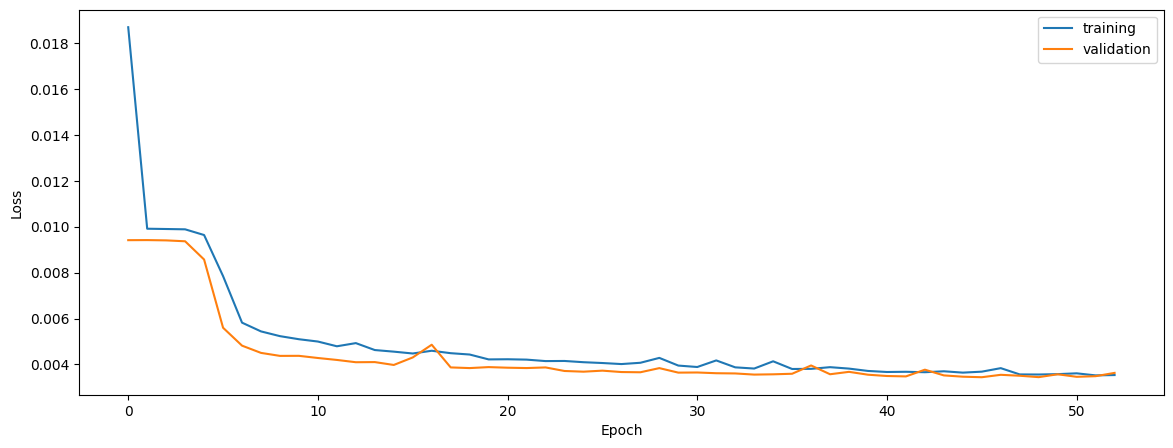

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


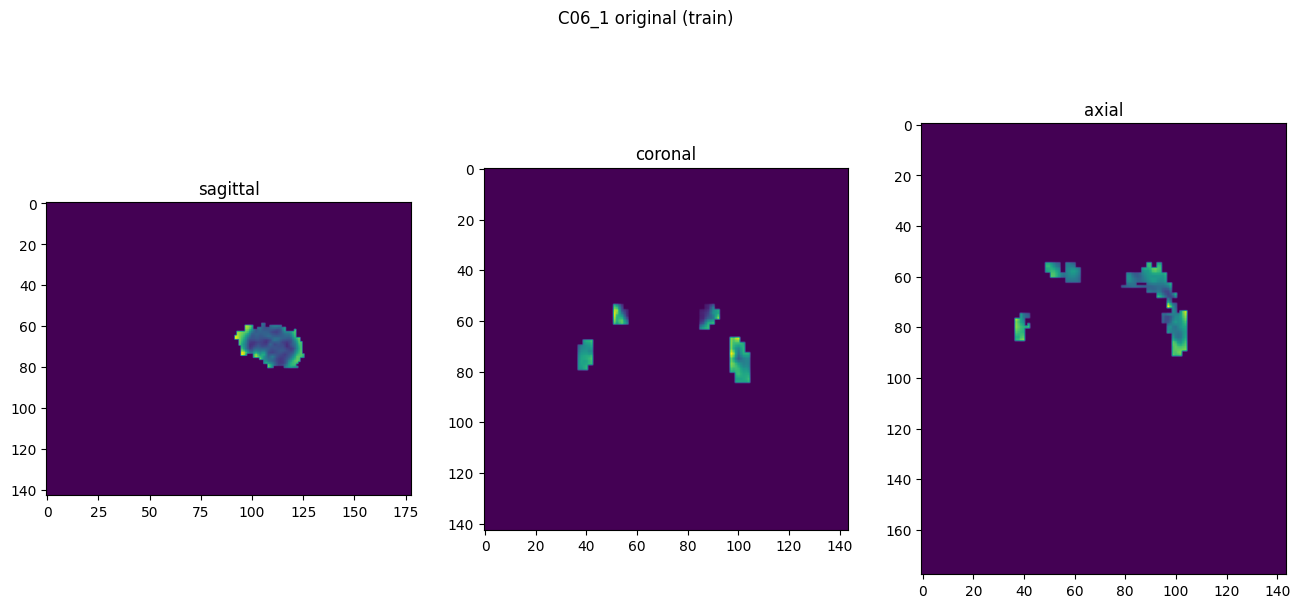

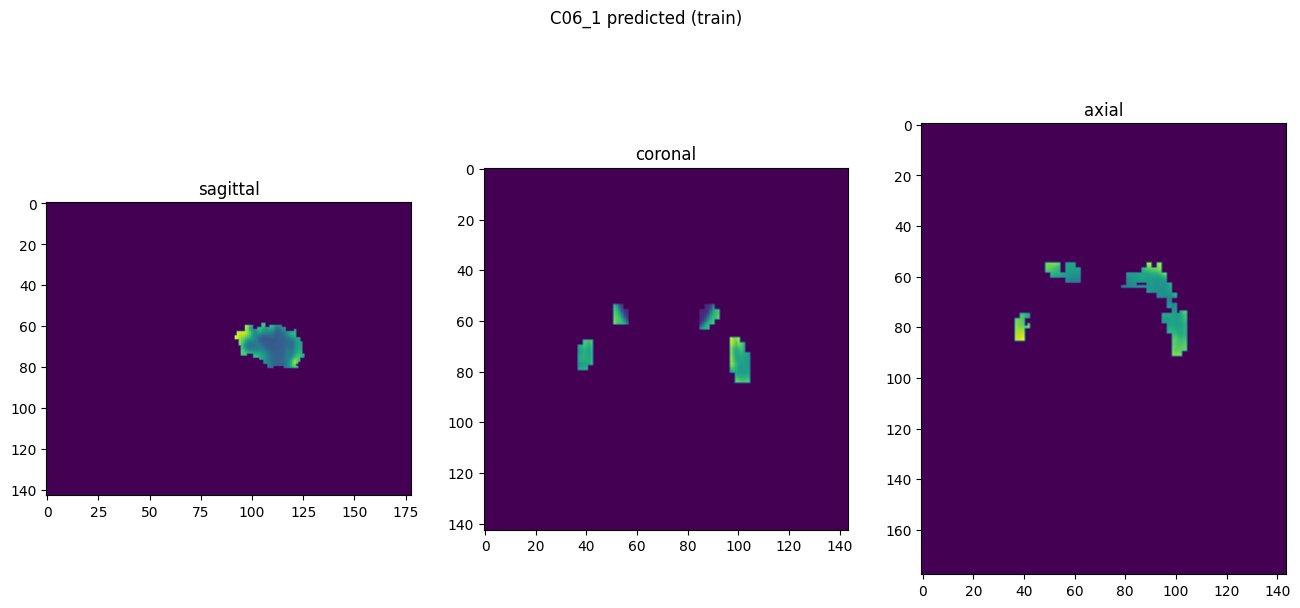

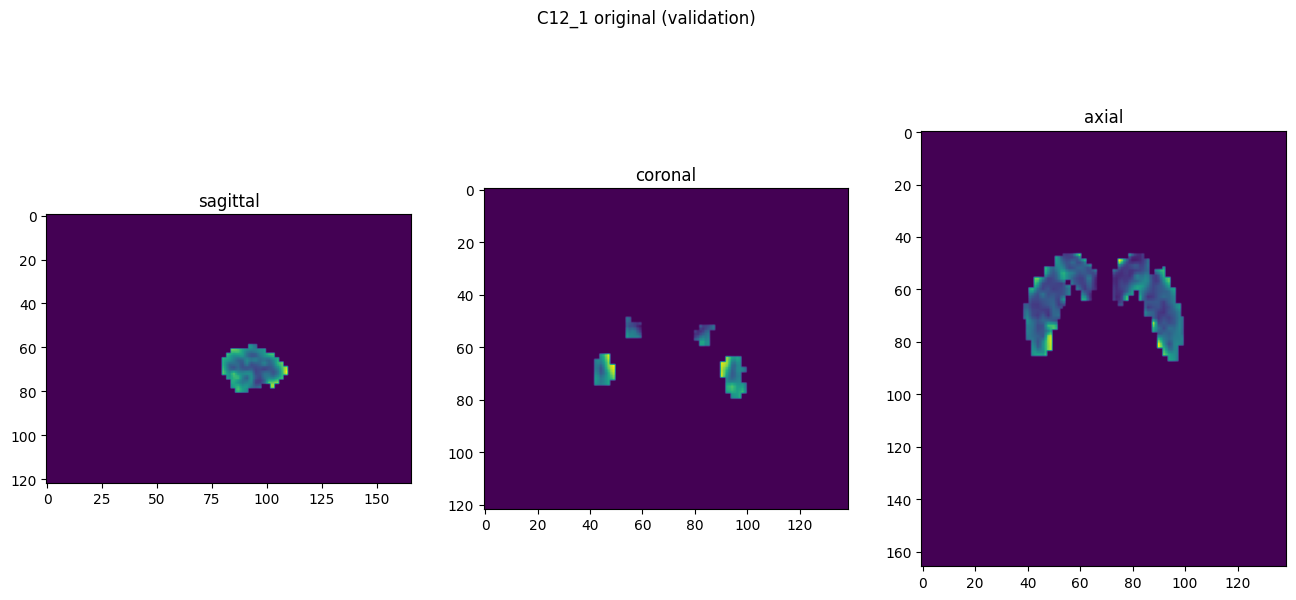

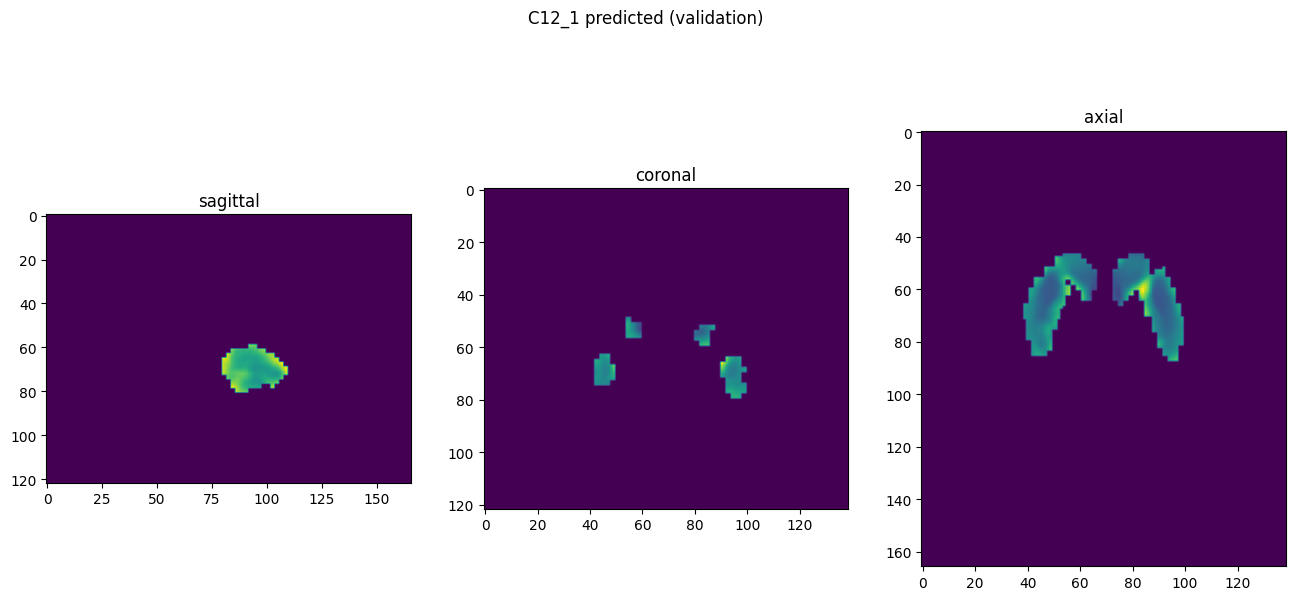

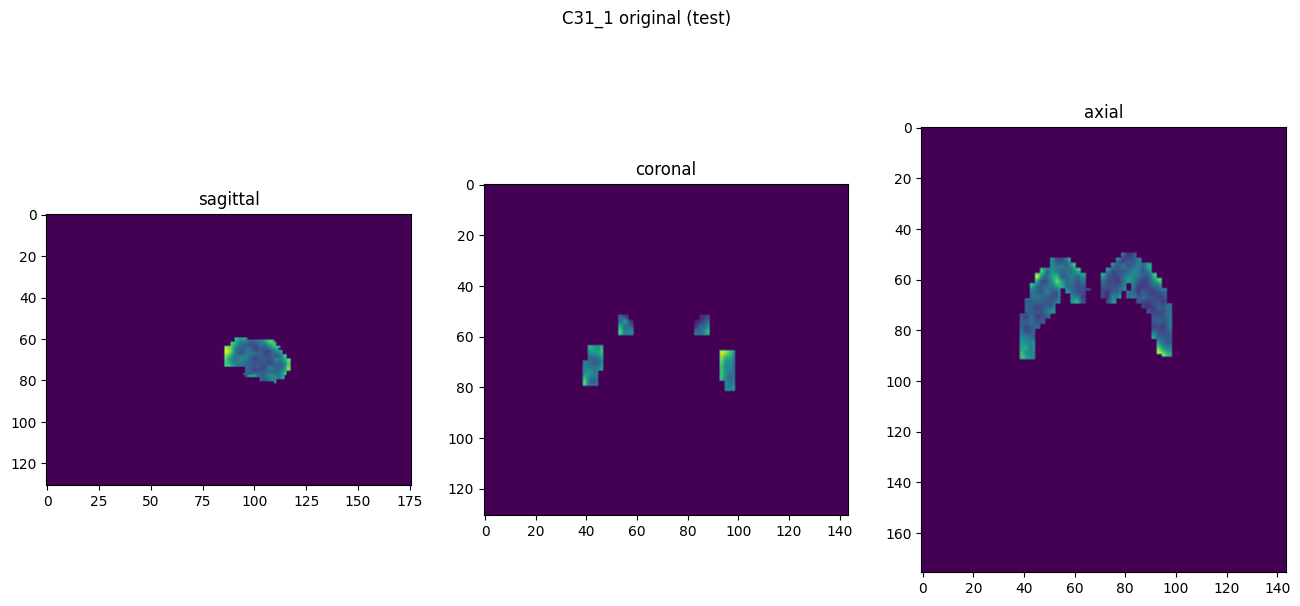

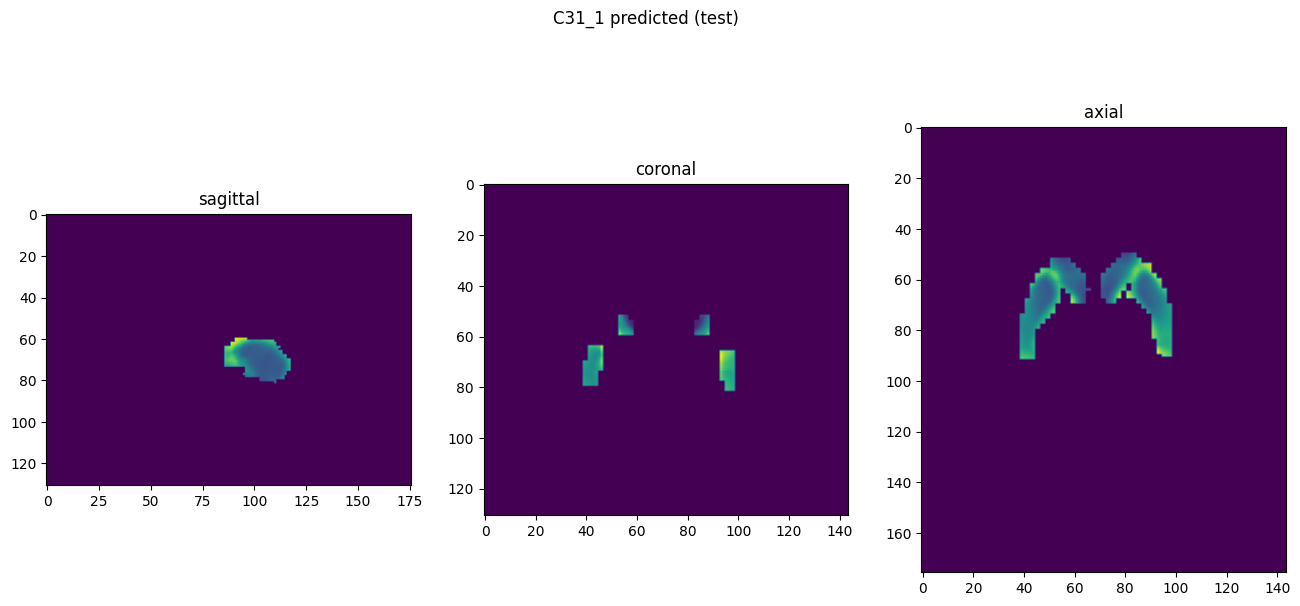

In [10]:
showResults(model, gen, threshold=None, background=False)